In [1]:
!pip install -r ../requirements.txt

In [77]:
import pandas as pd
from data.parliamentApiHelpers import ParliamentAPI
from data.generateJson import get_links
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

In [ ]:
# get XIV parliament data (coalition_XIV)
# add date column to votes data
# then pick a window (mayb 1 month?) and over each month, see correlation of votes between target party and all other parties, save to df
# plot as line chart

In [3]:
coalition = "XIV"
data_folder = f"../coalition_{coalition}"

In [119]:
party_to_short = {
    "Eesti Keskerakonna fraktsioon": "KESK",
    "Eesti Konservatiivse Rahvaerakonna fraktsioon": "EKRE",
    "Eesti Reformierakonna fraktsioon": "REF",
    "Fraktsiooni mittekuuluvad Riigikogu liikmed": "MITTEKUULUVAD",
    "Isamaa fraktsioon": "I",
    "Sotsiaaldemokraatliku Erakonna fraktsioon": "SDE"
}

In [120]:
df_votes = pd.read_parquet(f"{data_folder}/votes.parquet")
df_voters = pd.read_parquet(f"{data_folder}/voters.parquet")
voter_to_party = df_voters["faction"].to_dict()
df_vote_metadata = pd.read_parquet(f"{data_folder}/metadata.parquet")
df_vote_metadata["month"] = df_vote_metadata["date"].str[:7]
vote_to_month = df_vote_metadata["month"].to_dict()
months_unique = df_vote_metadata["month"].unique()
df_fractions = pd.read_parquet("../fractions.parquet")
df_fractions = df_fractions[(df_fractions.shortName.notna()) & (df_fractions.active)]
e200_id = "e4bf6970-f928-4230-961c-615cc54118f9"
df_fractions.loc[e200_id, "colorHex"] = "#008080"

In [133]:
short_to_color = df_fractions.set_index("shortName")["colorHex"].to_dict()

In [123]:
df_votes_used = df_votes.replace({"POOLT": 1, "VASTU": -1, "ERAPOOLETU": 0, "PUUDUB": 0, "EI_HAALETANUD": 0})

In [124]:
df_votes_used["month"] = df_votes_used.index.map(vote_to_month)

In [125]:
def get_corrs(df, month):
    return (df
            .query("month == @month")
            .corr(numeric_only=True)
            .rename(index=voter_to_party)
            .reset_index()
            .groupby("index")
            .mean()
            .T
            .rename(index=voter_to_party)
            .reset_index()
            .groupby("index")
            .mean()
            .rename(index=party_to_short, columns=party_to_short))

In [167]:
selected = "EKRE"
fractions = list(party_to_short.values())
fraction_corr_df = {fraction: [] for fraction in fractions}
for month in months_unique:
    month_votes_count = len(df_votes_used.query("month == @month"))
    if month_votes_count < 5:
        continue
    corrs = get_corrs(df_votes_used, month)
    # print(corrs[selected])
    for fraction in fractions:
        fraction_corr_df[fraction].append(
            pd.concat([
                corrs[fraction],
                pd.Series({"month":month})
            ])
        )
    #print(corrs)
for fraction in fractions:
    fraction_corr_df[fraction] = pd.DataFrame(fraction_corr_df[fraction])

In [127]:
# make figure

In [136]:
fractions

['KESK', 'EKRE', 'REF', 'MITTEKUULUVAD', 'I', 'SDE']

In [134]:
short_to_color

{'E200': '#008080',
 'KESK': '#3bac7b',
 'EKRE': '#2a3da0',
 'REF': '#ffc000',
 'MITTEKUULUVAD': '#c0c0c0',
 'I': '#6fabd4',
 'SDE': '#e35558'}

In [165]:
import matplotlib.dates as mdates

In [203]:
def plot_fraction_corrs(df_dict, fraction, rolling):
    df_corr_used = df_dict[fraction].set_index("month").rolling(rolling).mean()
    months = pd.to_datetime(df_corr_used.index, format="%Y-%m")
    locator = mdates.AutoDateLocator()
    plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    plt.gca().xaxis.set_major_locator(locator)

    for comparedFraction in fractions:
        if comparedFraction == "MITTEKUULUVAD":
            continue
        plt.plot(months, df_corr_used[comparedFraction], color=short_to_color[comparedFraction], label=comparedFraction)

    plt.gcf().autofmt_xdate()
    plt.ylabel("mean corr")
    plt.title(f"Mean of mean correlations between members of {fraction} and those of other fractions")
    plt.legend()
    plt.show()

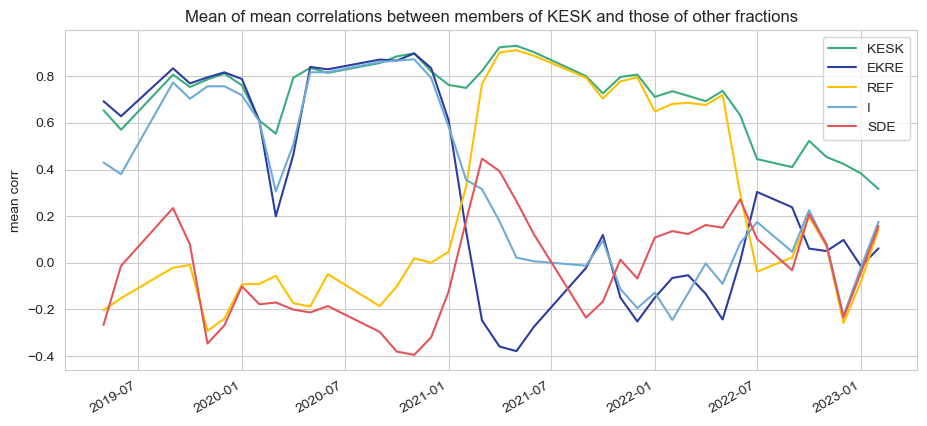

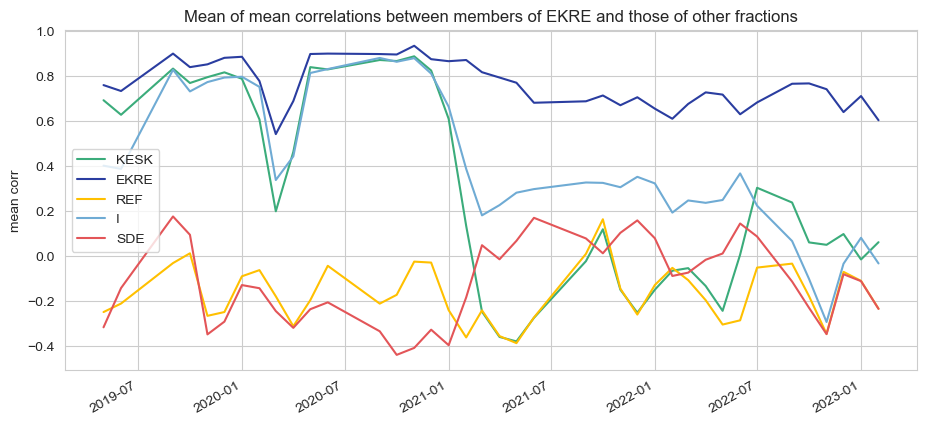

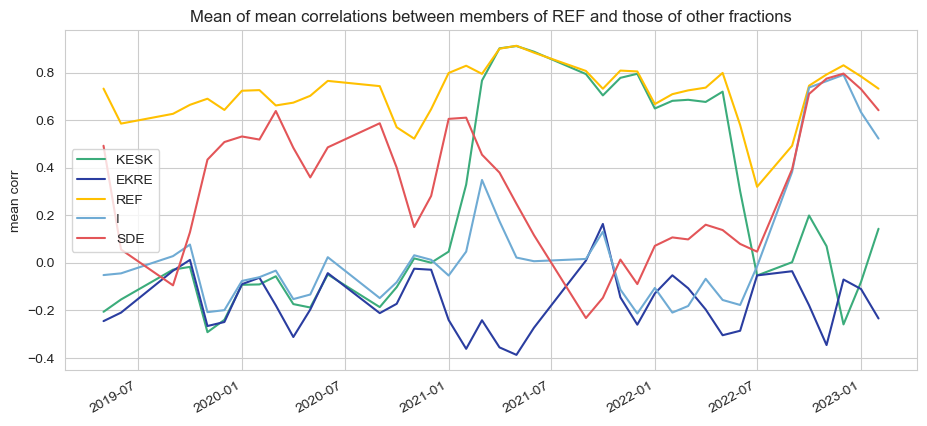

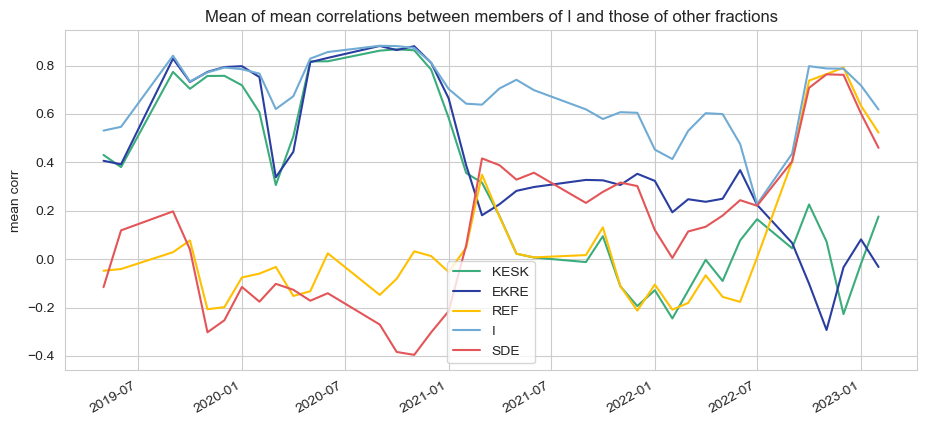

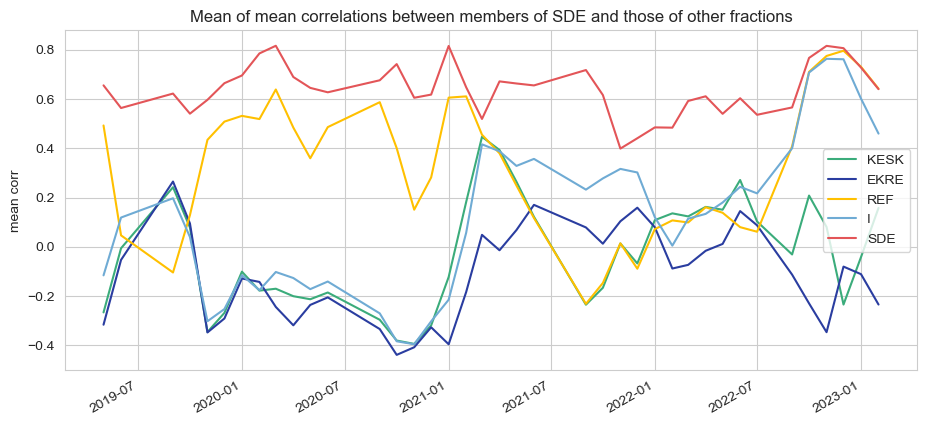

In [204]:
plt.rcParams["figure.figsize"] = (11, 5)

rolling = 2
for fraction in fractions:
    if fraction == "MITTEKUULUVAD":
        continue
    plot_fraction_corrs(fraction_corr_df, fraction, rolling)